**Loading and Exploring the dataset**

In [52]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Augmentation for training, to get more diverse data from existing images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Clean transform for testing/validation
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


train_path = 'fruit_dataset/train'
test_path = 'fruit_dataset/test'

# labels the images based on folder names.
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

# DataLoaders helps in batching, shuffling, and loading images efficiently.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class labels
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


Visualizing images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to 

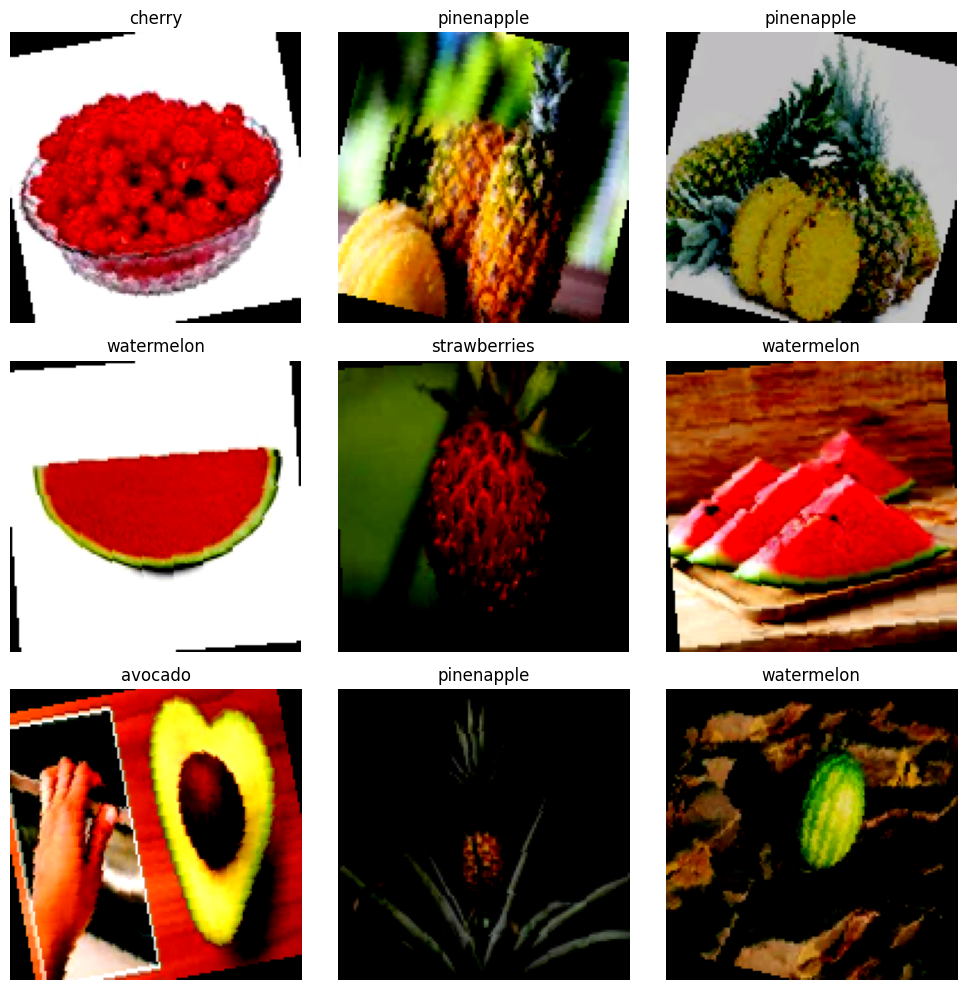

In [53]:
# Visualize a few training images
import numpy as np

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy format
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 10))
for idx in range(9):
    plt.subplot(3, 3, idx+1)
    imshow(images[idx], class_names[labels[idx]])
plt.tight_layout()
plt.show()


Counting Images

In [54]:
from collections import Counter

labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count} images")


Apple: 230 images
Banana: 230 images
avocado: 230 images
cherry: 230 images
kiwi: 230 images
mango: 231 images
orange: 230 images
pinenapple: 230 images
strawberries: 230 images
watermelon: 230 images


Data Cleaning for unwanted images

In [55]:
from PIL import UnidentifiedImageError

bad_images = []
for img_path, _ in train_dataset.samples:
    try:
        with Image.open(img_path) as img:
            img.verify()
    except (UnidentifiedImageError, IOError):
        bad_images.append(img_path)

print(f"Found {len(bad_images)} bad images")


Found 0 bad images


Defining a CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # adjust if input image size changes
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# We don’t apply Softmax here, because nn.CrossEntropyLoss() expects raw logits and internally applies it.

What Happens to an Image (128×128)?
conv1: Input [3, 128, 128] → Output [32, 128, 128]
pool1: [32, 128, 128] → [32, 64, 64]
conv2: [32, 64, 64] → [64, 64, 64]
pool2: [64, 64, 64] → [64, 32, 32]
Flatten: 64*32*32 = 65536 features
fc1: 65536 → 128
fc2: 128 → num_classes

**Setup a training loop**

In [57]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training the model

In [58]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


In [59]:
train(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 1.9443, Accuracy: 27.73%
Epoch [2/10], Loss: 1.5258, Accuracy: 43.50%
Epoch [3/10], Loss: 1.3766, Accuracy: 49.72%
Epoch [4/10], Loss: 1.2681, Accuracy: 54.24%
Epoch [5/10], Loss: 1.1732, Accuracy: 56.63%
Epoch [6/10], Loss: 1.0944, Accuracy: 59.97%
Epoch [7/10], Loss: 1.0278, Accuracy: 62.41%
Epoch [8/10], Loss: 0.9608, Accuracy: 65.02%
Epoch [9/10], Loss: 0.9124, Accuracy: 67.06%
Epoch [10/10], Loss: 0.8770, Accuracy: 68.58%


Test the model

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [61]:
class_names = ['Apple', 'Banana', 'Blueberry', 'Guava', 'Mango',
                'Orange', 'Peach', 'Pineapple', 'Strawberry', 'Watermelon']

evaluate(model, test_loader, class_names)


Classification Report:
              precision    recall  f1-score   support

       Apple       0.71      0.51      0.59        89
      Banana       0.13      0.13      0.13       105
   Blueberry       0.02      0.02      0.02       106
       Guava       0.48      0.80      0.60       105
       Mango       0.56      0.54      0.55       105
      Orange       0.46      0.26      0.33       105
       Peach       0.63      0.87      0.73        97
   Pineapple       0.62      0.86      0.72       105
  Strawberry       0.50      0.39      0.44       103
  Watermelon       0.62      0.40      0.49       105

    accuracy                           0.47      1025
   macro avg       0.47      0.48      0.46      1025
weighted avg       0.47      0.47      0.45      1025

Confusion Matrix:
[[45  2  1 16  3  4  3  3  8  4]
 [ 1 14 51  3 12  4  1  7  0 12]
 [ 0 47  2  1  6 12 14 21  0  3]
 [ 1  0  1 84  1  1  3  5  8  1]
 [ 1 14 17  1 57  6  3  6  0  0]
 [ 4 20  9  0 13 27 24  7  0  1]
 [

Confusion matrix

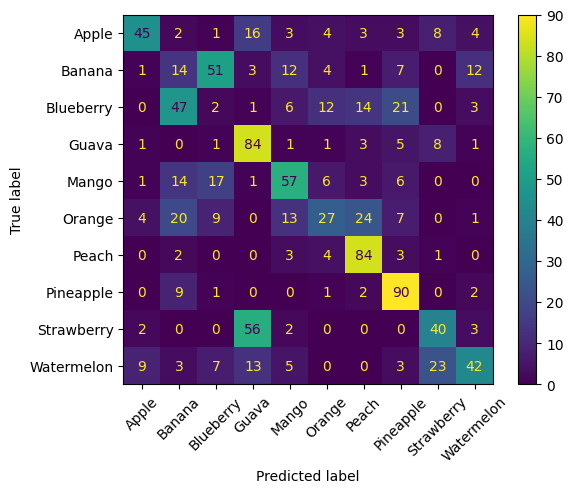

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.show()


In [63]:
torch.save(model.state_dict(), 'fruit_model.pth')